In [12]:
N = 10000 #no of points to generate
d = 3 #no of features (visualisation only for d==2)
#choose the pattern to fit (0,1,2,3,4,5)
surface_type=2
#add noise
Noise = 0.0/d





from itertools import chain
%matplotlib inline
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import numpy as np
import pandas as pd
from bokeh.plotting import figure, show, output_file, output_notebook, reset_output, ColumnDataSource
import matplotlib.pyplot as plt
from itertools import chain
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

In [13]:


#N = 1500 #no of points to generate
#d = 2 #no of features (visualisation only for d==2)

x = np.random.rand(N, d) * 100


#choose the pattern to fit (0,1,2,3,4,5)
#surface_type=0


#conic potential centered at x0, with a given radius
def conic(x, x0, radius):
    return radius - np.linalg.norm(x-x0)

#floored conic potential
def floored_conic(x, x0, radius, floor=0.):
    return max(radius - np.linalg.norm(x-x0), floor)

#level surface types
def level_func(x, type=0):
    if type==0: #centre
        f = floored_conic(x, 50.*np.ones((1,d)), 36., -10.) - 1.
    elif type==1: #corner
        f = floored_conic(x,  0.*np.ones((1,d)), 80., -10.) - 1.
    elif type==2: #two humps
        f = floored_conic(x,  0.*np.ones((1,d)), 55., -5.) + floored_conic(x,  100.*np.ones((1,d)), 22.,-5) + 8.
    
    elif type==3: #centre
        f = conic(x, 50.*np.ones((1,d)), 36.) - 1.
    elif type==4: #corner
        f = conic(x,  0.*np.ones((1,d)), 80.) - 1.
    elif type==5: #two humps, using low floors
        f = floored_conic(x,  0.*np.ones((1,d)), 55., -20) + floored_conic(x,  100.*np.ones((1,d)), 22., -20.) + 25.
        
    else:
        print("level_func: Unknown pattern type", type)
        f = None
    return f

#visualisation of the level function
#works for 2d only
if d<=2:
    xrng=(0,100)
    yrng=(0,100)
    plot_step=2
    xx, yy = np.meshgrid(np.arange(xrng[0], xrng[1], plot_step),
                         np.arange(yrng[0], yrng[1], plot_step))
    xx_scaled = np.c_[xx.ravel(), yy.ravel()]
    Z = np.zeros((xx_scaled.shape[0],1))
    for idx in range(xx_scaled.shape[0]):
        Z[idx] = level_func(xx_scaled[idx,:], type=surface_type)
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(xx,yy,Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

#level surface (values at x)    
surf = np.zeros((N,))
for i in range(N): #for each x
    surf[i] = level_func(x[i,:], type=surface_type)
    
#add noise
#Noise = 1.2/d
surf = surf + np.random.randn(N)*np.std(surf)*Noise



from skimage import measure

#show input data if d==2
if d<=2:
    #plot
    radii = np.ones((N,)) * 1. #marker radius
    
    c0 = "blue"
    c1 = "red"
    color = [c0 if f<0 else c1 for f in surf]

    df=pd.DataFrame({**dict(zip(["x"+str(i) for i in range(d)], [x[:,i] for i in range(d)])),
                     **{"color":color, "radii": radii, "level": surf, 
                     "class": [0. if f<0 else 1. for f in surf]}})

   
    
    source1 = ColumnDataSource(data = df)
    TOOLS="hover,pan,wheel_zoom,zoom_in,zoom_out,box_zoom"

    p = dict([])
    for i in range(d):
        for j in range(i+1, d):
            TOOLTIPS = [("value", "$level"),
                        (f"(x{str(i)},x{str(j)})", f"($x{str(i)}, $y{str(j)})")
            ]
            p[(i,j)] = figure(tooltips=TOOLTIPS, tools=TOOLS, x_range = (0.,100.), y_range=(0.,100.),
                  title=f"True: {i} vs. {j}", plot_width=int(1000/(d-1)) + (d==2)*(600-1000), plot_height=int(1000/(d-1))+ (d==2)*(600-1000))
            p[(i,j)].scatter(f"x{str(i)}", f"x{str(j)}", source = source1, radius="radii",
              fill_color="color", fill_alpha=0.6,
              line_color=None)

             #draw the true boundary line

            xrng=(0,100)
            yrng=(0,100)
            plot_step=.2
            xx, yy = np.meshgrid(np.arange(xrng[0], xrng[1], plot_step),
                                 np.arange(yrng[0], yrng[1], plot_step))
            xx_scaled=np.c_[xx.ravel(), yy.ravel()]
            Z = np.zeros((xx_scaled.shape[0],1))
            for idx in range(xx_scaled.shape[0]):
                Z[idx] = level_func(xx_scaled[idx,:], type=surface_type)
            Z = Z.reshape(xx.shape)

            contours = measure.find_contours(Z, 0.)
            for contour in contours:
                line_x = contour[:,1]*plot_step
                line_y = contour[:,0]*plot_step
                p[(i,j)].line(line_x, line_y, color='black', line_width=6, alpha=.6)


    f1=p[(0,1)]
    reset_output()
    output_notebook()
    show(p[(0,1)]) 

else:
    df = pd.DataFrame({**dict(zip(["x"+str(i) for i in range(d)], [x[:,i] for i in range(d)])),
                     **{"level": surf, 
                     "class": [0. if f<0 else 1. for f in surf]}})
    
#print class balance   
print("{:d}({:.3f}) class0, {:d}({:.3f}) class1".format(sum(df["class"] == 0.), sum(df["class"]==0.)/df.shape[0],
                                                        sum(df["class"]==1.), sum(df["class"]==1.)/df.shape[0]))

#utility function to visualise classification results
def show_clf2d(predict_method, sourcedata, transformer=None, label="", shadealpha=.2, linealpha = None):
    d = len([x for x in df.columns if x[0]=="x"]) #should be a better way to pass it
    if d>2:
        return None
    
    #show source data
    source1 = ColumnDataSource(data = sourcedata)
    i=0
    j=1
    
    TOOLS="hover,pan,wheel_zoom,zoom_in,zoom_out,box_zoom"
    TOOLTIPS = [("value", "$level"),
                    (f"(x{str(i)},x{str(j)})", f"($x{str(i)}, $y{str(j)})")]
                    
    p = figure(tooltips=TOOLTIPS, tools=TOOLS, x_range = (0.,100.), y_range=(0.,100.), title=label)

    p.scatter(f"x{str(i)}", f"x{str(j)}", source = source1, radius="radii",
          fill_color="color", fill_alpha=0.6,
          line_color=None)

    
    #now shade the classifier areas
    xrng=(0,100)
    yrng=(0,100)
    plot_step=.2
    xx, yy = np.meshgrid(np.arange(xrng[0], xrng[1], plot_step),
                         np.arange(yrng[0], yrng[1], plot_step))

    if transformer is None:
        xx_scaled=np.c_[xx.ravel(), yy.ravel()]
    else:
        xx_scaled=transformer.transform(np.c_[xx.ravel(), yy.ravel()]) #use when data is transformed pre-training
        
    Z = predict_method(xx_scaled).reshape(xx.shape)

    #color the areas
    p.image(image = [Z], x=xrng[0], y=yrng[0], dw=xrng[1]-xrng[0], dh=yrng[1]-yrng[0], 
            palette=[c0,c1],
       global_alpha=shadealpha)
    
    
    #contour line
    if not linealpha is None:
        levels = [0,1]  
        for level in levels:
          contours = measure.find_contours(Z, level)
          for contour in contours:
            x = contour[:,1]*plot_step
            y = contour[:,0]*plot_step
            p.line(x, y, color='black', line_width=4, alpha=linealpha)

    output_notebook()
    show(p)
    return p

8892(0.889) class0, 1108(0.111) class1


In [14]:
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.preprocessing import StandardScaler

### Data pre-processing
X = x
y = df["class"].values
y = pd.DataFrame.from_dict(y)
y = y.iloc[:, :]
y = y[0].apply(lambda x: 0 if x <= 0 else 1)

y = y.to_numpy()
#Xnorm = minmax_scale(X, feature_range=(0, np.pi))
#X_train_val, X_test, y_train_val, y_test = train_test_split(Xnorm, y, test_size=0.5)

#y = y.iloc[:, :]
#y = y[0].apply(lambda x: 1 if x <= 0 else -1)
#y = y.to_numpy()
Xnorm = minmax_scale(X, feature_range=(0, 2* np.pi))

### SPLITTING DATA 
#X_train_val, X_test, y_train_val, y_test = train_test_split(Xnorm, y, test_size=0.2, random_state=1)

<Figure size 432x288 with 0 Axes>

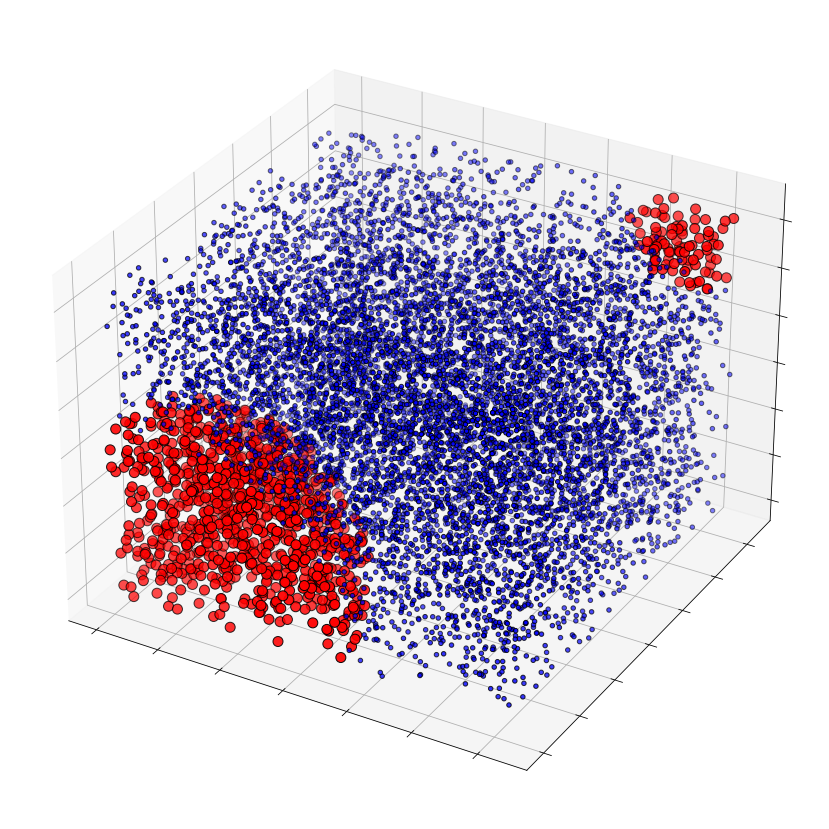

In [15]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
fig= plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(Xnorm[:, 0][y == 1], Xnorm[:, 1][y == 1], Xnorm[:, 2][y == 1], c="r", marker="o", edgecolors="k",s=100)
ax.scatter(Xnorm[:, 0][y == 0], Xnorm[:, 1][y == 0], Xnorm[:, 2][y == 0], c="b", marker="o", edgecolors="k",s=20)

#ax.set_xlabel('X Label')
#ax.set_ylabel('Y Label')
#ax.set_zlabel('Z Label')
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
plt.show()

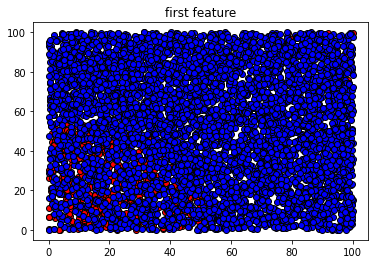

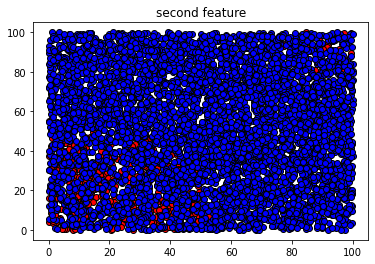

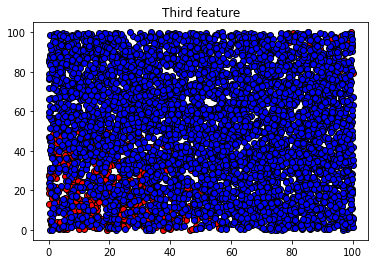

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1], c="r", marker="o", edgecolors="k")
plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0], c="b", marker="o", edgecolors="k")
plt.title("first feature")
plt.show()

plt.figure()
plt.scatter(X[:, 1][y == 1], X[:, 2][y == 1], c="r", marker="o", edgecolors="k")
plt.scatter(X[:, 1][y == 0], X[:, 2][y == 0], c="b", marker="o", edgecolors="k")
plt.title("second feature")
plt.show()

plt.figure()
plt.scatter(X[:, 0][y == 1], X[:, 2][y == 1], c="r", marker="o", edgecolors="k")
plt.scatter(X[:, 0][y == 0], X[:, 2][y == 0], c="b", marker="o", edgecolors="k")
plt.title("Third feature")
plt.show()

In [6]:
#X = pd.DataFrame(X)
#y = pd.DataFrame(y)
#X.to_pickle("X_ST2_N01")
#y.to_pickle("y_ST2_N01")

In [7]:
X_train = Xnorm[:3000]
y_train = y[:3000]
X_val = Xnorm[3000:4000]
y_val = y[3000:4000]
X_test = Xnorm[3000:6000]
y_test = y[3000:6000]
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt

# save to csv file
savetxt('X_train_N00.csv', X_train, delimiter=',')
savetxt('y_train_N00.csv', y_train, delimiter=',')
savetxt('X_val_N00.csv', X_val, delimiter=',')
savetxt('y_val_N00.csv', y_val, delimiter=',')
savetxt('X_test_N00.csv', X_test, delimiter=',')
savetxt('y_test_N00.csv', y_test, delimiter=',')

In [8]:
count0Train = (y_train == 0).sum()
count1Train = (y_train == 1).sum()
count0Val = (y_val == 0).sum()
count1Val = (y_val == 1).sum()
count0Test = (y_test == 0).sum()
count1Test = (y_test == 1).sum()

print('Total occur "0" in TRAIN: ', count0Train)
print('Total occur  "1" in TRAIN: ', count1Train)
print('Total occur "0" in VAL: ', count0Val)
print('Total occur "1" in VAL: ', count1Val)
print('Total occur "0" in TEST: ', count0Test)
print('Total occur "1" in TEST: ', count1Test)

Total occur "0" in TRAIN:  2654
Total occur  "1" in TRAIN:  346
Total occur "0" in VAL:  878
Total occur "1" in VAL:  122
Total occur "0" in TEST:  2681
Total occur "1" in TEST:  319
